## Imports

In [1]:
from vpython import *
import numpy as np
import matplotlib.pyplot as pyplt
import random
from collections import deque

<IPython.core.display.Javascript object>

## Simulation

### Simulation Setup

In [13]:
# attack parameters
injection_attack = False
delay_attack = False
denial_attack = False
triple_redundancy = False

# scene setup
scene = canvas(title="Inverted Pendulum Balancer", width=800, height=400)

#----------------------------------------------------------------------
# define a cylinder to act as our pendulum
pend = cylinder(pos=vec(0, 0, 0), axis=vec(0, 1, 0), radius=0.04, length=1, color=vec(1, 0, 0))
pend.mass = 1
pend.theta = np.pi / 2 - 0.1
pend.thetaDot = 0

# define a clyinder to act as the rail our pendulum is attached to
rail = cylinder(pos=vec(0, 0, 0), axis=vec(1, 0, 0), radius=0.1, length=30, color=vec(0, 1, 0))
rail.pos.x = -rail.length / 2
rail.pos.y = -rail.radius

positionOutput = wtext(text='Position={:f}'.format(0))

#----------------------------------------------------------------------
class PerceivedPendulum:
    # This class holds the system's perceived values for the pendulum.
    # What it "believes" the pendulum's pos, angle, angular velocity are.
    # These values can be altered by attacks.
    def __init__(self, pend):
        self.pos = vec(pend.pos.x, 0, 0)
        self.theta = pend.theta
        self.thetaDot = pend.thetaDot

perceived = PerceivedPendulum(pend)
perceived.pos.x = pend.pos.x
perceived.theta = pend.theta
perceived.thetaDot = pend.thetaDot

perceived2 = PerceivedPendulum(pend)
perceived2.pos.x = pend.pos.x
perceived2.theta = pend.theta
perceived2.thetaDot = pend.thetaDot

perceived3 = PerceivedPendulum(pend)
perceived3.pos.x = pend.pos.x
perceived3.theta = pend.theta
perceived3.thetaDot = pend.thetaDot

#----------------------------------------------------------------------
# constants
G = 9.8
damping = 0.02
coefficientOfRestitution = 0.8
collisions = False

targetPos = 2

# time
t = 0
endTime = 15
dt = 0.01
speedMultiplier = 1

# data storage
time_data = []
position_data = []
perceived_pos_data = []
angle_data = []
perceived_angle_data = []

#----------------------------------------------------------------------
def getControlSignal(perceived, perceived2, perceived3, desiredPosition):
    # simple PD controller
    # theta_error = np.pi / 2 - perceived.theta
    # theta_dot_error = -perceived.thetaDot
    # position_error = perceived.pos.x - xPos

    if triple_redundancy:
        # Check if two of the sensors match, if so they have a 2/3 majority and win the vote
        if perceived.theta == perceived2.theta:
            targetTheta = perceived.theta
        elif perceived.theta == perceived3.theta:
            targetTheta = perceived.theta
        elif perceived2.theta == perceived3.theta:
            targetTheta = perceived2.theta
            
        if perceived.thetaDot == perceived2.thetaDot:
            targetThetaDot = perceived.thetaDot
        elif perceived.thetaDot == perceived3.thetaDot:
            targetThetaDot = perceived.thetaDot
        elif perceived2.thetaDot == perceived3.thetaDot:
            targetThetaDot = perceived2.thetaDot
            
        if perceived.pos.x == perceived2.pos.x:
            targetX = perceived.pos.x
        elif perceived.pos.x == perceived3.pos.x:
            targetX = perceived.pos.x
        elif perceived2.pos.x == perceived3.pos.x:
            targetX = perceived2.pos.x
    else:
        targetTheta = perceived.theta
        targetThetaDot = perceived.thetaDot
        targetX = perceived.pos.x
    
    theta_error = np.pi / 2 - targetTheta
    theta_dot_error = -targetThetaDot
    position_error = targetX - desiredPosition

    # gain values
    Kp_theta = 10
    Kd_theta = 4
    Kp_position = 2

    return Kp_theta * theta_error + Kd_theta * theta_dot_error + Kp_position * position_error

#----------------------------------------------------------------------
def updatePend(pend, dt):

    # if injection attack, inject false data
    if injection_attack:
        inject_false_data(perceived)

    xDot = getControlSignal(perceived, perceived2, perceived3, targetPos) # use percieved values, as this is what the system believes its values are

    # apply control signal to real pendulum values
    pend.pos.x += xDot*dt    
    pend.theta += np.arctan(xDot*dt/pend.length) # my system hates atan() and needs arctan() spelled out
    pend.theta %= np.pi*2

    torque = -G*pend.mass*pend.length/2*np.cos(pend.theta) - pend.thetaDot*damping
    moment = 0.333*pend.mass*pend.length**2
    thetaDoubleDot = torque/moment
    
    pend.thetaDot += thetaDoubleDot*dt
    pend.theta += pend.thetaDot*dt

    # add current real state to the delay buffer
    if delay_attack:
        delay_buffer.append({
            'pos': pend.pos.x,
            'theta': pend.theta,
            'thetaDot': pend.thetaDot
        })
        
    # if delay is enabled and we have enough captured frames, use delayed data
    if delay_attack and len(delay_buffer) > delay_frames:
        delayed = delay_buffer[-delay_frames]
        perceived.pos.x = delayed['pos']
        perceived.theta = delayed['theta']
        perceived.thetaDot = delayed['thetaDot']
    
    # otherwise use real position or deny
    elif not denial_attack or random.random() > deny_rate:
        perceived.pos.x = pend.pos.x
        perceived.theta = pend.theta
        perceived.thetaDot = pend.thetaDot

    # Sensors 2 and 3 have been overlooked by the attacker and always get the correct
    perceived2.pos.x = pend.pos.x
    perceived2.theta = pend.theta
    perceived2.thetaDot = pend.thetaDot
    perceived3.pos.x = pend.pos.x
    perceived3.theta = pend.theta
    perceived3.thetaDot = pend.thetaDot

    # update visuals
    pend.axis = rotate(vec(1, 0, 0), pend.theta, vec(0, 0, 1))*pend.length
    positionOutput.text = 'Position={:f}'.format(pend.pos.x)
    
    return pend

#----------------------------------------------------------------------
# main loop
def simulateIPB(graphics = True):
    global pend, t, time_data, position_data, angle_data, perceived_pos_data, perceived_angle_data
    t = 0
    time_data = []
    position_data = []
    perceived_pos_data = []
    angle_data = []
    perceived_angle_data = []
    pend.pos.x = 0
    pend.theta = np.pi / 2 - 0.1
    pend.thetaDot = 0
    while t < endTime:
        pend = updatePend(pend, dt * speedMultiplier)
    
        # collect real data
        time_data.append(t)
        position_data.append(pend.pos.x)
        degrees = pend.theta * (180/np.pi) # convert angle to degrees
        angle_data.append(degrees)
    
        # collect perceived data
        perceived_pos_data.append(perceived.pos.x)
        perceived_deg = perceived.theta * (180/np.pi) # convert angle to degrees
        perceived_angle_data.append(perceived_deg)
    
        t += dt
        if graphics:
            rate(1 / dt)
    
        # scene display
        display = (
        f"Simulation time: {t:.2f}/{endTime:.2f}\n"
        f"Real Position: {pend.pos.x:.2f}\n"
        f"Perceived Pos: {perceived.pos.x:.2f}\n"
        f"Real Angle: {degrees:.2f}\n"
        f"Perceived Angle: {perceived_deg:.2f}\n"
        )
        scene.caption = (display)



<IPython.core.display.Javascript object>

### Base Simulation

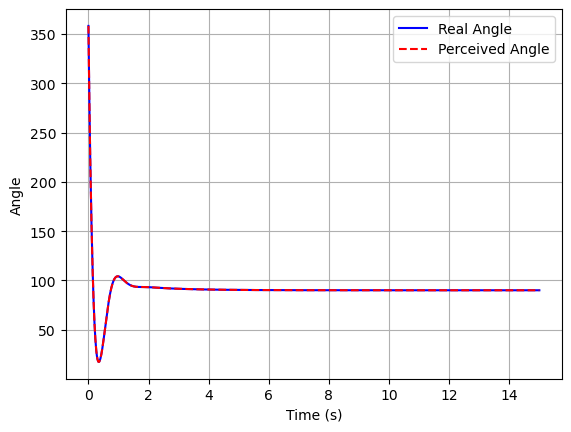

In [3]:
simulateIPB()

#----------------------------------------------------------------------
# plotting results
pyplt.plot(time_data, angle_data, label='Real Angle', color='blue')
pyplt.plot(time_data, perceived_angle_data, label='Perceived Angle', color='red', linestyle='--')

#pyplt.plot(time_data, position_data, label='Real Position', color='blue')
#pyplt.plot(time_data, perceived_pos_data, label='Perceived Position', color='red', linestyle='--')

pyplt.ylabel("Angle")
#pyplt.ylabel("Position")
pyplt.xlabel("Time (s)")
pyplt.legend()
pyplt.grid()
pyplt.show()

### Injection Attack

**targeted_data** can be: 
"position" to trick the system into thinking it is in the wrong location, or
"theta" to trick the system into thinking the pendulum is tipping

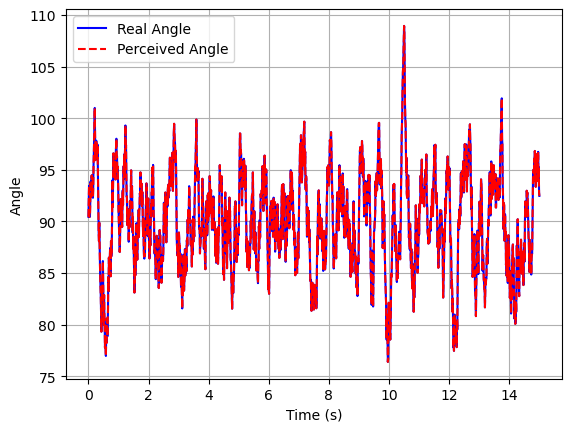

In [4]:
injection_attack = True
injection_rate = 1
attack_severity = 0.5
targeted_data = "theta"

def inject_false_data(perceived):
    # shift percieved vars from actual values
    if random.random() < injection_rate:
        shift = random.uniform(-attack_severity, attack_severity)

        if targeted_data == "position":
            perceived.pos.x += shift
        elif targeted_data == "theta":
            perceived.theta += shift

simulateIPB()

#----------------------------------------------------------------------
# plotting results
pyplt.plot(time_data, angle_data, label='Real Angle', color='blue')
pyplt.plot(time_data, perceived_angle_data, label='Perceived Angle', color='red', linestyle='--')

#pyplt.plot(time_data, position_data, label='Real Position', color='blue')
#pyplt.plot(time_data, perceived_pos_data, label='Perceived Position', color='red', linestyle='--')

pyplt.ylabel("Angle")
#pyplt.ylabel("Position")
pyplt.xlabel("Time (s)")
pyplt.legend()
pyplt.grid()
pyplt.show()

### Deny Attack

In [13]:
denial_attack = True
injection_attack = False
delay_attack = False
deny_rate = 1 # percent of packets denied

simulateIPB()

#----------------------------------------------------------------------
# plotting results
pyplt.plot(time_data, angle_data, label='Real Angle', color='blue')
pyplt.plot(time_data, perceived_angle_data, label='Perceived Angle', color='red', linestyle='--')

#pyplt.plot(time_data, position_data, label='Real Position', color='blue')
#pyplt.plot(time_data, perceived_pos_data, label='Perceived Position', color='red', linestyle='--')

pyplt.ylabel("Angle")
#pyplt.ylabel("Position")
pyplt.xlabel("Time (s)")
pyplt.legend()
pyplt.grid()
pyplt.show()

### Delay Attack

In [ ]:
delay_attack = True
denial_attack = False
injection_attack = False
delay_frames = 10  # how many frames of delay
delay_buffer = deque(maxlen=50) # to hold delayed frames

simulateIPB()

#----------------------------------------------------------------------
# plotting results
pyplt.plot(time_data, angle_data, label='Real Angle', color='blue')
pyplt.plot(time_data, perceived_angle_data, label='Perceived Angle', color='red', linestyle='--')

#pyplt.plot(time_data, position_data, label='Real Position', color='blue')
#pyplt.plot(time_data, perceived_pos_data, label='Perceived Position', color='red', linestyle='--')

pyplt.ylabel("Angle")
#pyplt.ylabel("Position")
pyplt.xlabel("Time (s)")
pyplt.legend()
pyplt.grid()
pyplt.show()

### Time to failure analysis
Here we will run the simulation many times with different parameters, and graph the time until failure v.s. the parameter

#### Injection attack
We can change the attack severity and rate parameters

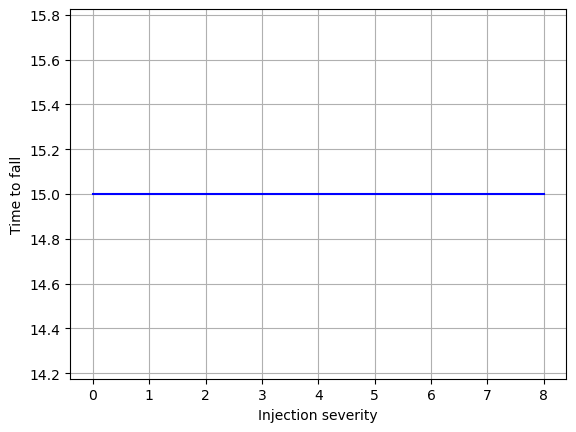

In [10]:
injection_attack = True
denial_attack = False
delay_attack = False
injection_rate = 1
attack_severity = 0.1
targeted_data = "theta"

def inject_false_data(perceived):
    # shift percieved vars from actual values
    if random.random() < injection_rate:
        shift = random.uniform(-attack_severity, attack_severity)

        if targeted_data == "position":
            perceived.pos.x += shift
        elif targeted_data == "theta":
            perceived.theta += shift


severities = np.linspace(0, 8, 50)
timesToFall = []
for severity in severities:
    attack_severity = severity
    simulateIPB(graphics = False)
    fallen = False
    timeToFall = 0
    for i, ang in enumerate(angle_data):
        if ang < 0 or ang > 180:
            fallen = True
            timeToFall = time_data[i]
            # print(timeToFall, ang)
            break
    if timeToFall == 0:
        timeToFall = 15
    timesToFall.append(timeToFall)
        
    

#----------------------------------------------------------------------
# plotting results
pyplt.plot(severities, timesToFall, color='blue')

#pyplt.plot(time_data, position_data, label='Real Position', color='blue')
#pyplt.plot(time_data, perceived_pos_data, label='Perceived Position', color='red', linestyle='--')

pyplt.ylabel("Time to fall")
#pyplt.ylabel("Position")
pyplt.xlabel("Injection severity")
pyplt.grid()
pyplt.show()

## Countermeasures
### Triple redundancy

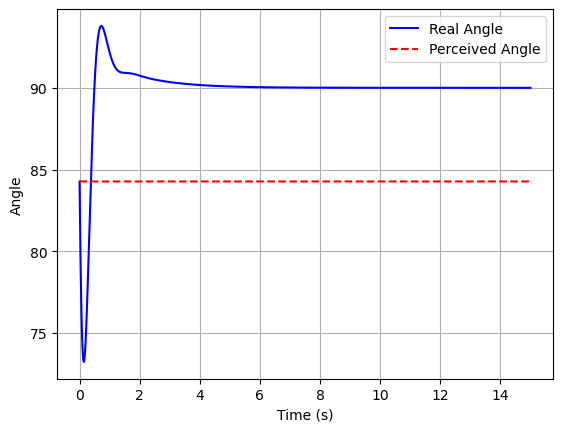

In [15]:
denial_attack = True
injection_attack = False
delay_attack = False
deny_rate = 1 # percent of packets denied
triple_redundancy = True

simulateIPB()

#----------------------------------------------------------------------
# plotting results
pyplt.plot(time_data, angle_data, label='Real Angle', color='blue')
pyplt.plot(time_data, perceived_angle_data, label='Perceived Angle', color='red', linestyle='--')

#pyplt.plot(time_data, position_data, label='Real Position', color='blue')
#pyplt.plot(time_data, perceived_pos_data, label='Perceived Position', color='red', linestyle='--')

pyplt.ylabel("Angle")
#pyplt.ylabel("Position")
pyplt.xlabel("Time (s)")
pyplt.legend()
pyplt.grid()
pyplt.show()

We can see that the perceived angle is wrong, but the real angle stays near 90 because the other two sensors vote and overwrite the attacked sensor which is what we are graphing